<a href="https://colab.research.google.com/github/cedamusk/AI-N-ML/blob/main/Ordinal_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ordinal Logistic Regression

## Install mord
To run the code for Ordinal Logistic Regression, the `mord` library must be installed. This library provides tools for odinal regression, which handles problems where the target variable has a natural order but no consistent difference between categories.

In [2]:
!pip install mord

  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9886 sha256=8af04226999362140f80a18a892abb5f228b4fc142843c204b09a76b45ab42af
  Stored in directory: /root/.cache/pip/wheels/d1/fc/57/f2a2ad4ed0491ab6d5bb8642a90f1da9469397641e914743da
Successfully built mord


## Import libraries
`numpy`: Provides support for numerical operations and handling arrays effeciently. It's commonly used for numerical computations.

`pandas`: A library for data manipulation and analysis, particularly useful for handling tabular data with its `DataFrame` structure.

`make_classification`: A utility function to generate synthetic datasets for classification problems, making it easier to test and validate models.

`train_test_split`: Splits the dataset into training and testing subsets for model evaluation.

`GridSearchCV`: Performs hyperparameter tuning using cross-validation to find the best combination of parameters.

`confusion_matrix`: Creates a matrix showing true positives, true negatives, false positives, and false negatives for classification results.

`accuracy_score`: Measures the overall accuracy of the model (correct predictions/ total predictions).

`precision_score`, `recall_score`, `f1_score`: Metrics for evaluating classification performance.

  **Precision**: Ratio of true positives to all predicted positives.

  **Recall**: Ratio of true positives to all actual positives.

  **F1 Score**: Harmoic mean of precision and recall, balancing both metrics.

`StanndardScaler`: Standardizes features by removing the mean and scaling to unit variance, improving model performance by ensuring all features are on the same scale.

`Pipeline`: Simplifies the process of applying a sequence of data preprocessing steps and model training, ensuring reproducibility.

`make_scorer`: Customizes scoring functions for model evaluation, allowing you to define metrics tailored to specific objectives.

`PCA` **(Principal Component Analysis)**: A dimensionality reduction technique used to reduce the number of features while retaining as much variance as possible.

`matplotlib.pyplot`: A plotting library for creating static, interactive, and animated visualizations.

`seaborn`: A library built on top of Matplotlib, offering high-level, aesthetically pleasing statistical plots.

`LogisticIT`: An implementation of ordinal logistic regression provided by the `mord` library. It models ordinal target variables by fitting an intercept and slope for each category.

`warnings.filterwarnings('ignore')`: Suppresses warning messages to avoid cluttering the output, especially durin iterative runs or when working with experimental features.

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from mord import LogisticIT
import warnings
warnings.filterwarnings('ignore')

## Create Ordinal Dataset
This function generates a synthetic dataset for ordinal regression, where the target variables has an ordered, categorical structure.

`n_samples`: Number of samples (data points) to generate (defaults: 1000).

`n_features`: Number of features (predictor variables) to generate (default: 5).

`n_classes`: Number of ordianl catgeories for the target variables ( default: 3).

`class_sep`: A scaling factor to control the separation between classes (default: 2.0).

In [4]:
def create_ordinal_dataset(n_samples=1000, n_features=5, n_classes=3, class_sep=2.0):
  X=np.random.randn(n_samples, n_features) #Generates a randome dataset of shape `(n_samples, n_features) using the standard normal distribution
  beta=np.random.randn(n_features) #Creates a random coefficient vector for features, represnting the relationship between predictors and the target variable
  z=np.dot(X, beta)
  # Computes a linear combination of features using the coefficient vector beta. This represents a contnuous latent variable (z) before mappig to ordinal categories.


  z=z-np.mean(z) #Centers the latent variable z around zero by subtracting its mean
  z=z*class_sep/np.std(z)#Scales the latent variable by the class_sep factor, which controls te spread (or separation) between categories

  thresholds=np.linspace(z.min(), z.max(), n_classes+1)[1:-1]
  """Computes evenly spaced thresholds between minimum and maxmimum values of z to define the the boundaries
  between ordinal categories

  np.linspace: Generates n_classes+1 equally spaced values.

  [1:-1]: Selects the inner thresholds, leaving out the extreme edges.

  """
  y=np.zeros(n_samples, dtype=int) #Initializes the target variable y as an array of zeros, representing the base category
  for i, threshold in enumerate(thresholds):
    y[z> threshold] =i+1

#Loops through the the thresholds, assigning ordinal categories to y based on the values of z. Each threshold separates z into a higher category.

  return X, y

## Custom adjacency scorer
This function computes a custom scoring metric to evaluate the performance of an ordinal regression model. The metric checks how often the predicted ordinal category is within one adjacent level of the true label.

### Key insights


1.   **Metric type**: The metric is less strict than exact accuracy and is designed for ordinal problems where being close to the true value is acceptable.
2.   **Use case**: Particularly useful in ordinal classification tasks where small deviations from the true label are tolerable.

3.   **Interpretation**: A score of `1.0` indicates perfect adjacency (all predictions are within +/- of the true labels). Lower scores suggest that many predictions are far from the true labels.



In [5]:
def custom_adjacency_scorer(y_true, y_pred):

  """
  Compute a custom adjacency score for ordinal regression.

  Parameters:
  y_true: Array-like of shape (n_samples,)
    The True Ordinal Labels.
  y_pred: array-like of shape (n_samples,)
    The predicted ordinal labels

  Returns:
  float: The proportion of predictions that are within one level of the true labels.

  Description:

  The adjacency scoe evaluates the performance of ordinal regression allowing a tolerance of +/-1 between
  the predicted label (`y_pred`) and the true label (`y_true`). This is useful for ordinal problems where predictions
  close to the true value are still considered

  Formula:
  -For each sample, calculate `|y_true-y_pred|`
  -If the difference is <= 1, consider the prediction correct.
  -Compute the mean of all such correct predictions.

  Example:
  >>>>y_true=[2, 3, 4, 3]
  >>>>y_pred=[3, 3, 5, 2]
  >>>>custom_adjacency_scorer(y_true, y_pred)
  1.0 #All predictions are within +/-1 of the true labels.
  """
  return np.mean(np.abs(y_true-y_pred) <= 1)

## Dataset generation
This code uses the `create_ordinal_dataset` function to generate a synthetic dataset for ordinal logistic regression.

### Output


*   `X`: A NumPy array of shape `(1000, 5)` representing the feature matrix.
*   `y`: A NumPy array of shape `(1000, )` representing the ordinal target variable, with values in `{0, 1, 2}`

### Use case
This datasets is used to simulate ordinal regression scenarios, where the target variabl `y` represents ordered categoried. For examples:

*    Severity levels of a condition
*    Satisfaction ratings.



In [6]:
X, y=create_ordinal_dataset(
    n_samples=1000,#Generates 1,000 data samples (rows)
    n_features=5, #Each sample will have 5 features (columns)
    n_classes=3, #The target variable `y` will have 3 ordinal classes (e.g., 0, 1, 2)
    class_sep=2.0 #Specifies the separation between classes, where larger values make class boundaries more distinct
)

## Pipeline creation
The following code defines a pipeline for processing data and training The model. The pipeline ensures that data preprocessing and model fitting occur sequentially and effeciently.

A tool from `sklearn.pipeline.Pipeline` that allows chaining multiple data preprocessing and modelling steps into one object. It ensures the reproducibility and simplifies the code.

### Use case
This pipeline is designed for ordinal regression tasks where the target variable has a natural order. It automates preprocessing and modelling, ensuring all steps occur in the correct sequence.

### Key advantages
* **Scalability**: The pipeline can handle scaling, dimensionality reduction, and modelling for larger datasets.
* **Reproducibility**: It standardizes the workflow, making it easier to debug and share code.
* **Efficiency**: Integrates preprocessing and model training, eliminating manual steps.

In [7]:
pipeline=Pipeline([
    ('scaler', StandardScaler()), #Scales the features to have zero mean and unit variance.
    #Ensures that features are standardized, which is crucial for PCA and LogisticIT to perform optimally.

    ('pca', PCA(n_components=4)), #Performs Principal Component Analysis to reduce the dimensioality of the dataset
    #The dataset feature space is reduced to 4 components, capturing the most variance while discarding less informative features.

    ('ordinal', LogisticIT())#Fits the LogisticIT model from the `mord` library
    #LogisticIT performs ordinal logistic regression, predicting ordered categories
])

## Parameter grid for hypeparameter tuning
The following code snippet defines a parameter grid ofr tuning the `LogisticIT` model's hyperparameter within the pipeline using `GridSearchCV`.

1. `param_grid`: A dictionary that specifies hyperparamters to tune and their respective values for the `LogisticIT` model.

2. **Parameter being tuned
`ordinal_alpha`**: Refers to the regularization parameter (`alpha`) in the `LogisticIT` model.

* Controls the strength of regularization in the model.

* Smaller values (e.g., 0.001) correspond to weaker regularization.

* Larger values (e.g., 1.0) correspond to stronger regularization, which can prevent overfitting by penalizing large coefficients.

3. **`ordinal__`Prefix**

* Refers to the `LogisticIT` step in the pipeline.

* The prefix follows the `Pipeline` convention, where the stape name (`ordinal`) is prepended to the parameter name (`alpha`) using the double underscores (`__`).


###Purpose
* The grid defines a range of `alpha` values to find the optimal regularization strength for the model.

* Helps improve the model's performance by balancing bias and variance through cross-validation.

In [8]:
param_grid={
    'ordinal__alpha': [0.001, 0.01, 0.1, 1.0]
}

## Train-Test split
This code splits the dataset into training and testing subsets, ensuring the distribution of he target variable (`y`) is preserved across both sets.

###Explanation
1. **Function**: `train_test_split` from `sklearn.model_selection` is used to split the dataset into training and testing subsets.

2. **Parameters**:


*   `X`: The feature matrix of dhpe `(n_samples, n_features)`.
*   `y`: The target variable of shape `(n_samples)`.

*  `test_size=0.2`: Specifies the proportion of the dataset to allocate to the test set (20% in this case).

*  `random_state=42`: Ensures reproducibility by using a fixed seed for random number generation.

*  `stratify=y`: Ensures the target varaible (`y`) is stratified, meaning its class distribution is preserved in both training and testing sets.

3. **Outputs**:
*  `X_train`: Training feature matrix.
*  `X_test`: Testing feature matrix.
*   `y_train`: Training target labels.
*   `y_test`: Testing target labels.



###Purpose
* To evaluate the model's performance on unseen data (test set) after training it on the training set.

*  Stratification enesures that the proportions of each class in `y` remain consistent across both subsets, which is particularly important for ordinal regression tasks.



In [9]:
X_train, X_test, y_train, y_test=train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## GridSearchCV for hyperparameter tuning and  model evaluation
The followimg code snippet performs hyperparameter tuning and model eveluation using GridSearchCV, with multiple scoring metrics metrics, including accuracy and a custom adjacency score.

###Explanation
1. `GridSearchCV`:
* A tool for performing exhaustive search over a specified parameter grid to find the best hyperparameters for the model.

* It also handles cross-validation, ensuring the model is evaluated on multiple train-test splits.

2. **Parameters**:

* `pipeline`: The pipeline that includes data preprocessing and the LogiticIT model.
* `param_grid`: The hyperparameter grid to search over (in this case, for the `alpha` parameter of the LogisticIT model).
* `cv=5`: Th number of cross-validation folds (5-fold cross-validation).

* `scoring`:
  * `accuracy`: The standard accuracy metric, measuring the proportion of correct predictions.

  * `adjacency`: The custom adjacency score that checks how often the predicted class is with one adjacent level of the true class, created using the `custom_adjacency_scorer` function.

* `refit='adjacency'`:After the grid search completes, the best model is refitted using the adjacency score as the reference metric for model selection.

* `n_jobs=-1`: Uses all available CPU cores to perform parallel processing, speeding up the grid search.

###Purpose
* Hyperparameter tuning: The goal is to find the optimal value for `alpha` using cross-validation.
* Multiple scoring metrics: Evaluation is done using both accuracy and the custom adjacency sore, allowing a more nuanced understanding of the model's performance on ordinal data.

In [10]:
grid_search=GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring={
        'accuracy': 'accuracy',
        'adjacency': make_scorer(custom_adjacency_scorer)
    },
    refit='adjacency',
    n_jobs=-1
)

## Fit the best model
This code fits the grid seach using cross-validation and retrievs the best performing model based on the adjacency score.

###Explanation
1. `grid_search.fit(X_train, y_train)`:
* Trains the pipeline using GridSearchCV.
* Performs 5-fold cross-validation (`cv=5`) to evaluate different hyperparameter settings.
* Optimizes using the adjacency score (set in `refit='adjacency'`).

2. `grid_search.best_estimator_`:
* Retrieves the best model found during the grid search.
* This model is already trained and optimized using the best hyperparameter (`alpha` in `LogisticIT`).
* It can now be used for predictions on new data.

###Purpose
* Finda the optimal model for ordinal logistic regression based on cross-validation results.

* Automatically selects the best hyperparamter (`alpha` from `param_grid`).
* Prepares the best model for final evaluation for deployment.

In [11]:
grid_search.fit(X_train, y_train)
best_model=grid_search.best_estimator_

## Making predictions with the best model
After seecting the best model from GridSearchCV, we use it to make bth class predictions and probability estimates for each class.

###Explanation:
1. `best_model.predict(X_test)`:
* Predicts the most likely ordinal class for each sample in `X_test`.
2. `best_model.predict_proba(X_test)`:
* Returns the probability distribution over all possible ordinal classes for each sample.
* Output: `y_pred_proba`, a NumPy arra of shape `(n_samples, n_classes)`, where each row represents the predicted probability for each class.

###Purpose:
* `predict`: Assigns a simgle class label to each test sampl.
* `predict_proba()`: Provides probability estimates, which are useful for:
  * Uncertainty estimation (e.g., confidence levels for each prediction).
  * Threshols-based decision making (e.g., selecting class only if probability > 0.7).
  * Visualization of class probabilities.

In [12]:
y_pred=best_model.predict(X_test)
y_pred_proba=best_model.predict_proba(X_test)

## Model Evaluation Metrics
THis computes the evaluation metrics for ordinal logistic regression model.

###Explanation of Each Metric:
1. **Confusion Matrix**(`confusion_matrix`):

* A table that compares the predicted and actual class labels.
* Shows how well the model classifies each category.
* Helps identify misclassifications and adjacent errors.
2. **Accuracy Score** (`accuracy_score`):

* Measures the proportion of correctly predicted labels out of all samples.
*Formula:
$$
\text{Accuracy}= \frac{\text{Correct Predictions}}{\text{Total Samples}}
$$

* Good for balanced datasets but not ideal for ordinal regression where adjacent misclassifications are less severe.
3. **Precision** (`precision_score with average='weighted'`):

* Weighted average of per-class precision, considering class imbalance.
* Precision for class
$$
\text{Precision}_c=\frac{\text{TP}_c}{\text{TP}_c +\text{FP}_c}
$$

* Useful for measuring how many predicted positives were actually correct.
4. **Recall** (`recall_score with average='weighted'`):

* Measures the proportion of actual class instances correctly predicted.
Formula:
$$
\text{Recall}_c=\frac{\text{TP}_c}{\text{TP}_c + \text{FN}_c}
 $$
* High recall means fewer missed instances of a class.
5. **F1 Score** (`f1_score with average='weighted'`):

* Harmonic mean of precision and recall.
* Formula:
$$
F1=2 \times \frac{\text{Precision} \times \text{Reca;;}}{\text{Precision} + \text{Recall}}
$$

* Useful when balancing false positives and false negatives.


In [13]:
conf_matrix=confusion_matrix(y_test, y_pred)
accuracy=accuracy_score(y_test, y_pred)
precision=precision_score(y_test, y_pred, average='weighted')
recall=recall_score(y_test, y_pred, average='weighted')
f1=f1_score(y_test, y_pred, average='weighted')

## Displaying the Best model parameters
This code retreives and prints the optimal hyperparameters found during GridSearchCV

###Explanation
1. `grid_search.best_params_`:
*  A dictionary containing the best hyperparameter values found during the grid search.
* Since we turned `ordinal__alpha`, this output will show the optimal `alpha` value.

###Purpose
* Helps in understanding which hyperparameter setting produced the best model.
* Useful for fine tuning and comparison with other models.


In [14]:
print("\nBest Model Parameters:")
print(grid_search.best_params_)


Best Model Parameters:
{'ordinal__alpha': 0.001}


## Displaying cross-validation results
This part of the code prints the cross-validation results for each evaluation metric used during the grid search, specifically focusing on the mean test scores for each metric.

###Explanation
1. `grid_search.cv_results_`:
* A dictionary that contains all results from the cross-validation process during the grid search.

* The keys include:

  * `mean_test_score`: Mean rest scores for each parameter combination.
  * Other keys for each evaluation metric like `mean_test_accuracy`, `mean_test_adjacency`, e.t.c.

2. Iterating over `cv_results_`:
* The loop goes through all the keys in the `cv_results_`.
* It checks if the key starts with `'mean_test'` to filter for the mean test scores.

* `grid_search.best_index_` points to the index of the best-performing model in the grid search. The code then prints the corresponding score for each metric.

3. Printing scores:
* For each metric (e.g., accuracy, adjacency), the code prints the mean score corresponding to the best model.

###Purpose
* Displays the performance of the best model according to each evaluation metric.
* Helps in comparing the model's performance acrosss different metrics after hyperparameter tuning.

In [15]:
print("\nCross-validation results:")
for metric, scores in grid_search.cv_results_.items():
  if metric.startswith('mean_test'):
    print(f"{metric}:{scores[grid_search.best_index_]:.4f}")


Cross-validation results:
mean_test_accuracy:0.8975
mean_test_adjacency:1.0000


## Displaying model evaluation metrics
This code prints the evaluation metrics after testing the best model on the test set.

###Explanation
1. Metrics printed:
* Accuracy: The proportion of correctly classified samples.

* Precision: The proportion of positive predictions that are actually correct.

* Recall: The proportion of actual positives that were correctly identified.

* F1 Score: The harmonic mean of precision and recall, balancing both.

2. Formatting:

* `{:.4f}` ensures each value is printed with four decimal places for clarity.


####Purpose
* Summarizes the performance of the best model on the test set.
* Helps compare the model's effectiveness across different classification metrics.

In [16]:
print("\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Model Evaluation Metrics:
Accuracy: 0.9950
Precision: 0.9951
Recall: 0.9950
F1 Score: 0.9950


## Confusion matrix visualization
This code generates a heatmap representation of the confusion matrix to analyze the model's classification performance

###Explanation
1. `plt.figure(figsize=(10, 8))`:
* Creates a figure canvas with a width of 10 inches and heght of 8 inches.
* Ensures the heatmap has enough space to display labels and annotations clearly.

2. `sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlOrRd', ...)`:
* `conf_matrix`: The confusion matri containing classification results.
* `annot=True`: Displays the actual count values inside the heatmap cells/
*`fmt='d'`: Formats the numbers as integers
* `cmap='YlOrRd'`: Uses a  yello-orange-red colour map for better contrast.

3. `xticklabels=[f'Class{i}' for i in range(3)]` and `yticklabels=[f'Class{i}' for i in range(3)]`:
* Dynamically generates labels (`Class0`, `Class1`, `Class2`) for the axes.
* This ensures the confusion matrixlabels match the number of classes.

4. `plt.title('Confusion Matrix for Ordinal Logistic Regression')`:
* Sets the title for the plot.

5. `plt.xlabel('Predicted')` and `ply.ylabel('Actual')`:
* Labels the x-axis (predicted classes) and y-axis (actual classes).

6. `plt.tight_layout()`:
* Adjusts spacing to prevent overlapping labels.

7. `plt.show()`:
* Displays the heatmap.


###Purpose
* Visualizes the classification performance for ordinal logistic regression.
* Helps identify misclassifications and whether errors occur between adjacent classes (which is common in ordinal problems).

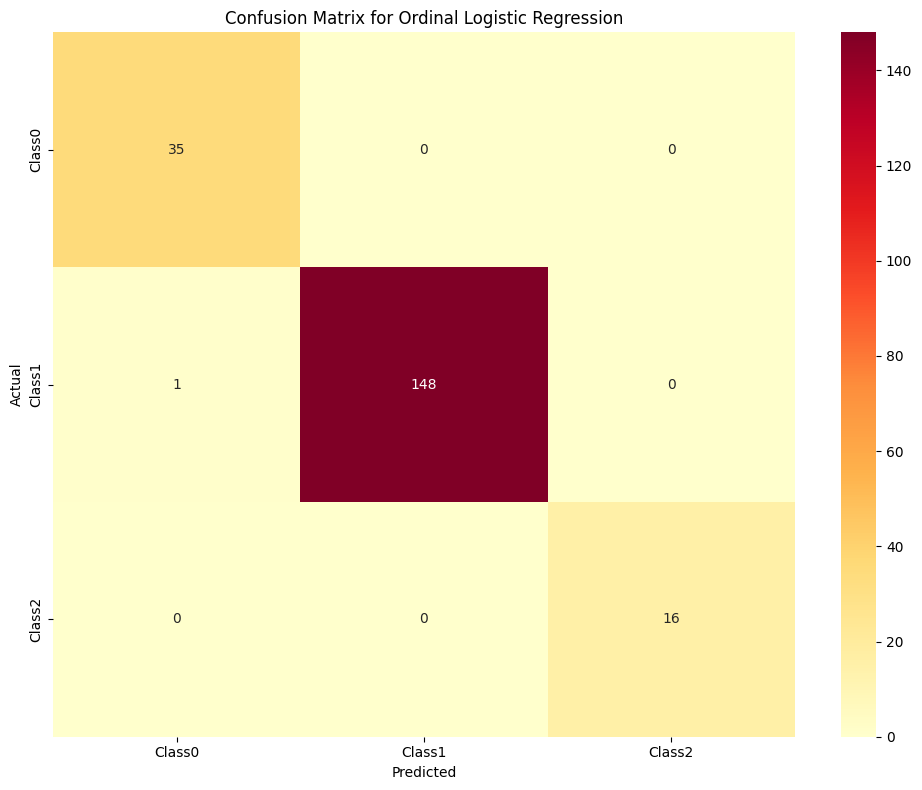

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=[f'Class{i}' for i in range(3)],
            yticklabels=[f'Class{i}' for i in range(3)])
plt.title('Confusion Matrix for Ordinal Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## Feature Importance
The following code extracts and plots the feature importance based on the absolute coefficient values from the trained Ordinal Logistic Regression model.

###Purpose
* Identifies which features have the greatest influence on predictions.
* Higher absolute coefficients indicate stronger impact on the target variable.
* Helps in feature selection- low importance features can be removed to simplify the model.

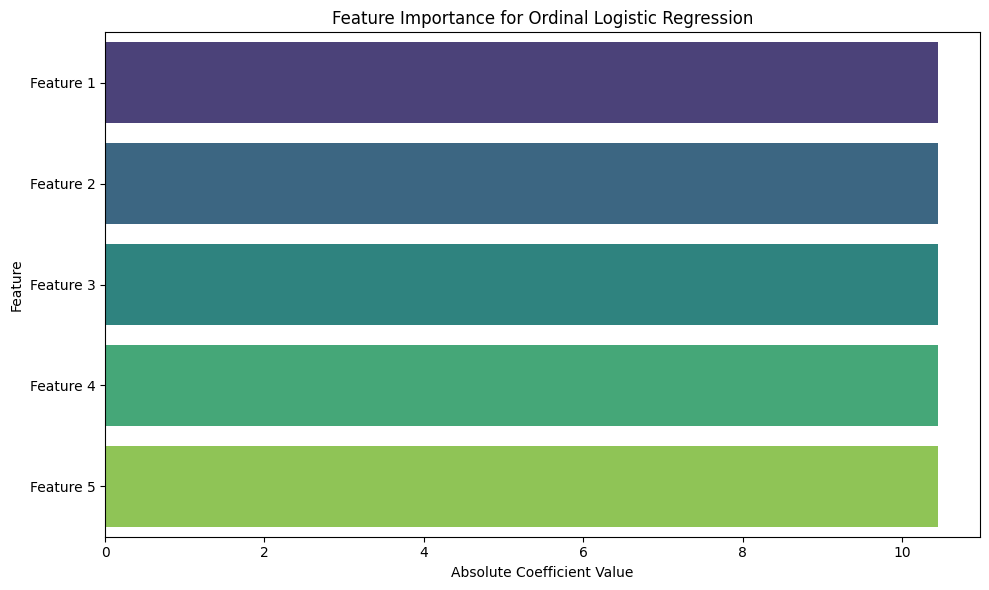

In [18]:
feature_importance=pd.DataFrame({
    'Feature':[f'Feature {i+1}' for i in range(5)],
    'Coefficient': np.abs(best_model.named_steps['ordinal'].coef_[0])
})
#Takes the absolute calue of the coefficients to measure feature importance
feature_importance=feature_importance.sort_values('Coefficient', ascending=False) #Sorts the features in descending order based on their coefficient values
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Coefficient', y='Feature', palette='viridis') #Creates a horizontal bar chart of feature importance
plt.title('Feature Importance for Ordinal Logistic Regression')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout() # Ensures labels and titles don't overlap
plt.show()

## Distribution of predicted probabilities
The code generates a Kenrnel Density Estimate (KDE) plot to analyze the distribution of predicted probabilities for each ordinal class.

###Explanation
* Analyzes the probability distribution assigned by the model to each class.
* Checks the model confidence- if the peaks are sharp, the model is confident in its preditions; if spread out, it is uncertain.
* Helps in threshold selsction, can inform decision-making if a certain probability threshold should be used instead of taking the highest probability.

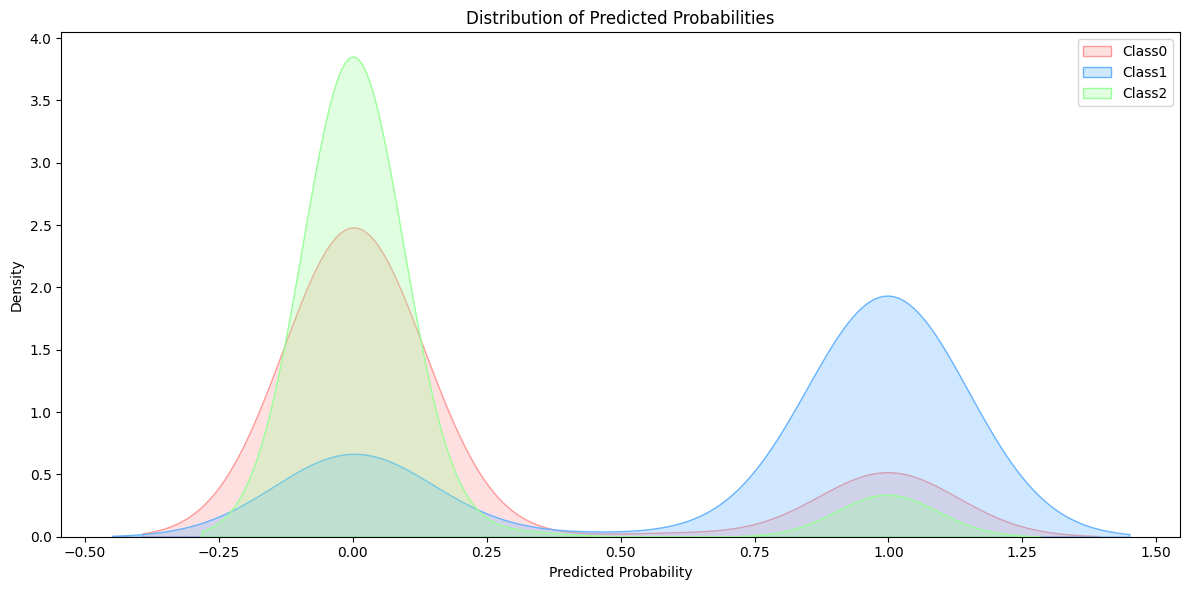

In [19]:
plt.figure(figsize=(12, 6))
colors=['#ff9999', '#66b3ff', '#99ff99']
for i in range(3):
  sns.kdeplot(y_pred_proba[:, i], label=f'Class{i}', color=colors[i], fill=True, alpha=0.3)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## Class-Specific Evaluation metrics
It computes and prints precision, recall and F1 Score for each class in the ordinal classification problem.

###Purpose
* Provides detailed performence insights for each ordinal class.
* Helps detect class imbalance issues, if precision or recall is low for a class, the model may struggle with that category.
* Useful for error analysis, if recall is low, the model is missiing instances of that class.

In [24]:
print("\nClass-specific Metrics:")
for i in range(3):
    class_mask = y_test == i
    class_precision = precision_score(y_test, y_pred, labels=[i], average='macro', zero_division=0)
    class_recall = recall_score(y_test, y_pred, labels=[i], average='macro', zero_division=0)
    class_f1 = f1_score(y_test, y_pred, labels=[i], average='macro', zero_division=0)

    print(f"\nClass {i}:")
    print(f"Class instances in test set: {sum(class_mask)}")
    print(f"Precision: {class_precision:.4f}")
    print(f"Recall: {class_recall:.4f}")
    print(f"F1 Score: {class_f1:.4f}")



Class-specific Metrics:

Class 0:
Class instances in test set: 35
Precision: 0.9722
Recall: 1.0000
F1 Score: 0.9859

Class 1:
Class instances in test set: 149
Precision: 1.0000
Recall: 0.9933
F1 Score: 0.9966

Class 2:
Class instances in test set: 16
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


## Calculating Adjacency accuracy for Ordianl Logistic Regression
It computes and prints the adjacency accuracy, which measures how often the predicted class is within one level of the true class.

In [21]:
adjacent_accuracy=np.mean(np.abs(y_test-y_pred)<=1)
print(f"\nadjacency Accuracy: {adjacent_accuracy:.4f}")


adjacency Accuracy: 1.0000


In [22]:
mae=np.mean(np.abs(y_test-y_pred))
mse=np.mean((y_test-y_pred)**2)
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

Mean Absolute Error: 0.0050
Mean Squared Error: 0.0050


In [23]:
print("\nClass Distribution:")
print("Training Set:")
for i in range(3):
  print(f"Class {i}: {np.mean(y_train==i):.2f}")
print("\nTest set:")
for i in range(3):
  print(f"Class {i}: {np.mean(y_test==i):.2%}")


Class Distribution:
Training Set:
Class 0: 0.18
Class 1: 0.74
Class 2: 0.08

Test set:
Class 0: 17.50%
Class 1: 74.50%
Class 2: 8.00%
